In [1]:
import ENDFtk
import ACEtk
import scion

import matplotlib.pyplot as plot
%matplotlib notebook

In [2]:
# the files we want to look at
endffile = '../performance/u235.endf'
acefile = '/Users/ftuser/Desktop/Lib80x/Lib80x/U/92235.800nc'    # Lib80x at 293.6 K (92235.800c)

In [3]:
# a few functions we need (these will be integrated into scion when from_endf(...) becomes available)

# convert to the proper Legendre coefficients
def convert( coefficients ) :
    
    converted = [ 0.5 ]
    for i in range( 1, len( coefficients ) + 1 ) :
        
        converted.append( ( 2 * i + 1 ) / 2 * coefficients[i - 1] )
    
    return converted

In [4]:
# open the ENDF file and retrieve the capture cross section
tape = ENDFtk.tree.Tape.from_file( endffile )
endf_elastic = tape.materials.front().file( 4 ).section( 2 ).parse()

print( 'number incident energies: ', len( endf_elastic.angular_distributions ) )

number incident energies:  126


In [5]:
# retrieve the ENDF data for 15 MeV
index = -17

incident_energy = endf_elastic.incident_energies[index]
endf_legendre = scion.math.LegendreSeries( convert( endf_elastic.angular_distributions[index].coefficients ) )
endf_table = scion.math.LinearLinearTable( endf_elastic.angular_distributions[index+1].cosines,
                                           endf_elastic.angular_distributions[index+1].probabilities )

print( 'incident energy: ', incident_energy, endf_elastic.incident_energies[index+1] )
print( 'order: ', endf_legendre.order )
print( 'coefficients: ', endf_legendre.coefficients )
print( 'number points: ', len( endf_table.x ) )

incident energy:  15000000.0 15000000.0
order:  58
coefficients:  [0.5, 1.36974705, 2.0209004999999998, 2.4748346, 2.7891, 3.0010018499999997, 3.1467624499999998, 3.22209, 3.2304122499999997, 3.150656, 2.9677672499999996, 2.62268195, 2.08835875, 1.4777424000000001, 0.9255206450000001, 0.513466485, 0.253491645, 0.1115205175, 0.04316305300000001, 0.015425463300000001, 0.0049809137, 0.0015020590149999998, 0.0004243896, 0.00011417496149999999, 2.9457525999999998e-05, 7.2939435e-06, 1.6774571550000001e-06, 3.07820975e-07, 1.04232195e-08, -2.6151809000000003e-08, -1.2162576500000002e-08, 6.9631065e-10, 5.0786450000000005e-09, 4.554291500000001e-09, 2.7487944e-09, 1.29764925e-09, 5.1331775e-10, 1.7473312500000001e-10, 5.2537870000000005e-11, 1.4162527500000001e-11, 3.4436380499999997e-12, 7.4533585e-13, 1.3545175e-13, 1.8809791499999997e-14, 4.4445621e-15, 5.237231999999999e-15, 5.204931e-15, 3.3045702500000003e-15, 6.0047365e-16, -2.26630305e-15, -5.1312545e-15, -7.974672e-15, -1.08642974999

In [6]:
# open the ACE file and retrieve the elastic angular distribution data
ace = ACEtk.ContinuousEnergyTable.from_file( acefile )

# reaction index = 0 for elastic (it's an ACE things)
ace_elastic = ace.angular_distribution_block.angular_distribution_data( 0 ).distributions[index]
ace_table = ace.angular_distribution_block.angular_distribution_data( 0 ).distributions[index+1]

print( 'zaid: ', ace.header.zaid )
print( 'temperature: ', ace.header.temperature )
print( 'number points: ', len( ace_elastic.cosines ) )
print( 'number points: ', len( ace_table.cosines ) )

zaid:  92235.800nc
temperature:  2.5301e-08
number points:  226
number points:  91


<IPython.core.display.Javascript object>


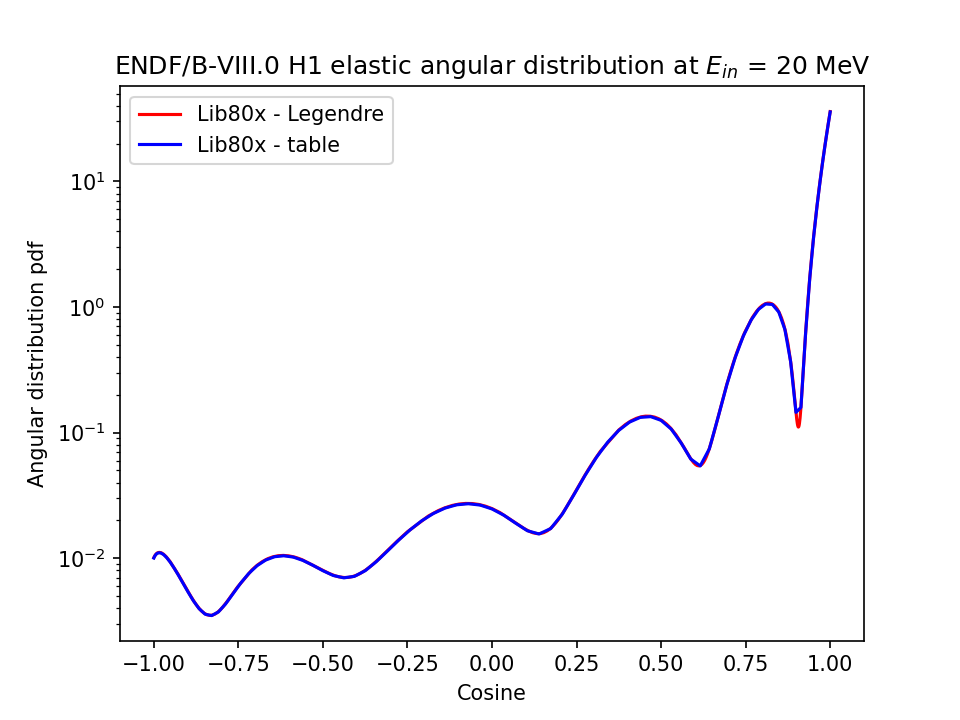

In [7]:
# plot the data
plot.figure()
plot.plot( ace_elastic.cosines, ace_elastic.pdf, label = 'Lib80x - Legendre', color = 'red', linewidth = 1.5 )
plot.plot( ace_table.cosines, ace_table.pdf, label = 'Lib80x - table', color = 'blue', linewidth = 1.5 )
plot.xlabel( 'Cosine' )
plot.ylabel( 'Angular distribution pdf' )
plot.title( 'ENDF/B-VIII.0 H1 elastic angular distribution at $E_{in}$ = 20 MeV' )
plot.yscale( 'log' )
plot.legend()
plot.show()

<IPython.core.display.Javascript object>


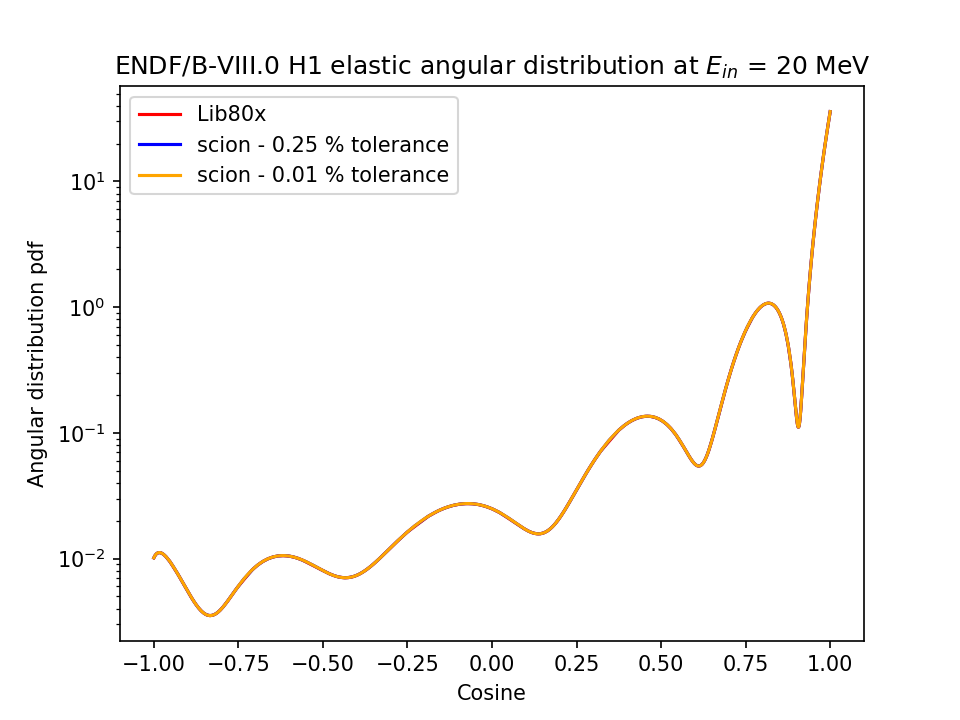

In [8]:
# linearise the pdf at different tolerances
plot1 = endf_legendre.linearise( scion.linearisation.ToleranceConvergence( .0025 ) )
plot2 = endf_legendre.linearise( scion.linearisation.ToleranceConvergence( .0001 ) )

# plot the data
plot.figure()
plot.plot( ace_elastic.cosines, ace_elastic.pdf, label = 'Lib80x', color = 'red', linewidth = 1.5 )
plot.plot( plot1.x, plot1.y, label = 'scion - 0.25 % tolerance', color = 'blue', linewidth = 1.5 )
plot.plot( plot2.x, plot2.y, label = 'scion - 0.01 % tolerance', color = 'orange', linewidth = 1.5 )
plot.xlabel( 'Cosine' )
plot.ylabel( 'Angular distribution pdf' )
plot.title( 'ENDF/B-VIII.0 H1 elastic angular distribution at $E_{in}$ = 20 MeV' )
plot.yscale( 'log' )
plot.legend()
plot.show()

In [9]:
print( len( ace_elastic.cosines ) )
print( len( plot1.x ) )
print( len( plot2.x ) )

226
257
1255


<IPython.core.display.Javascript object>


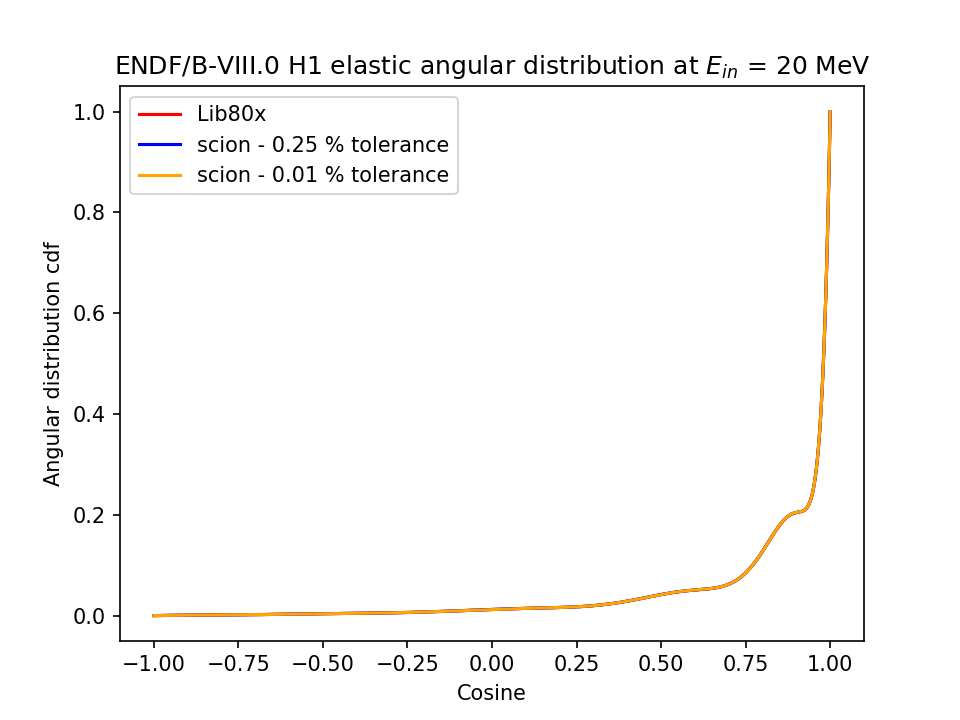

In [11]:
# we can linearise the cdf directly based on the primitive of the pdf as a Legendre series
endf_cdf = endf_legendre.primitive( -1.0 ) # the integral[-1,x] of the endf_legendre series

plot1 = endf_cdf.linearise( scion.linearisation.ToleranceConvergence( .0025 ) )
plot2 = endf_cdf.linearise( scion.linearisation.ToleranceConvergence( .0001 ) )

# plot the data
plot.figure()
plot.plot( ace_elastic.cosines, ace_elastic.cdf, label = 'Lib80x', color = 'red', linewidth = 1.5 )
plot.plot( plot1.x, plot1.y, label = 'scion - 0.25 % tolerance', color = 'blue', linewidth = 1.5 )
plot.plot( plot2.x, plot2.y, label = 'scion - 0.01 % tolerance', color = 'orange', linewidth = 1.5 )
plot.xlabel( 'Cosine' )
plot.ylabel( 'Angular distribution cdf' )
plot.title( 'ENDF/B-VIII.0 H1 elastic angular distribution at $E_{in}$ = 20 MeV' )
plot.yscale( 'linear' )
plot.legend()
plot.show()

In [11]:
print( len( ace_elastic.cosines ) )
print( len( plot1.x ) )
print( len( plot2.x ) )

226
115
560


In [12]:
# we can verify that the pdf never goes below zero in [-1,1] by calculating the roots of the pdf on the real axis
print( 'roots: ', endf_legendre.roots() )

roots:  [-27490.864496728645, 27491.02615564107]


In [13]:
# we can verify that the cdf is monotonically increasing in [-1,1] by calculating the roots of the 
# first derivative of the cdf on the real axis and showing that the derivative is always above zero
# and yes: I know that boils down to calculating the roots of the pdf but I'm flexing the interface here :-)
print( 'roots: ', endf_legendre.primitive( -1 ).derivative().roots() )

roots:  [-29041.29413192659, 29041.253301480956]
